In [4380]:
import numpy as np
import random
from dataclasses import dataclass
from tqdm.auto import tqdm
from typing import List

In [4381]:
problem = np.load('../data/problem_3.npz')
x = problem['x']
y = problem['y']

print(x.shape)
print(y.shape)
PROBLEM_SIZE = x.shape[0]

POPULATION_SIZE = PROBLEM_SIZE*20
OFFSPRING_SIZE = int(POPULATION_SIZE*0.5)
MAX_GENERATIONS = 200
INCREASE_COMPLEXITY_STEP = 20

(3, 5000)
(5000,)


In [4382]:
rng = np.random.Generator(np.random.PCG64([POPULATION_SIZE, OFFSPRING_SIZE, MAX_GENERATIONS, INCREASE_COMPLEXITY_STEP]))

In [4383]:
# Operators

BINARY_OPERATORS = ["+", "-", "*", "/"]
UNARY_OPERATORS = ["sin", "cos","tan", "exp", "log","arcsin","arccos","arctan","sqrt","abs"]
VARIABLES = ["X_"+str(i) for i in range(PROBLEM_SIZE)]

VARIABLES_WEIGHTS = [[1/len(VARIABLES) for _ in range(len(VARIABLES))]]
VARIABLES_MAP = {var: i for i,var in enumerate(VARIABLES)}

In [4384]:
@dataclass
class Individual:
    genome: list
    fitness: tuple

In [4385]:
def compute_MSE(Y_pred, Y_real):
    
    MSE = 100*np.square(Y_real-Y_pred).sum()/len(Y_real)
    return MSE

In [4386]:
def compute_unary_weights(unary_operators,j):
    """
    Compute unary operators weights depending on functions dominion and relation between input and output
    """
    W = {op: 0 for op in unary_operators}

    # Funzioni di dominio
    def is_valid_tan(x,curr):
        return np.abs(np.cos(x)) > 1e-9 and curr != -1

    def is_valid_log(x,curr):
        return x > 0 and curr != -1

    def is_valid_sqrt(x,curr):
        return x >= 0 and curr != -1

    def is_valid_arcsin_arccos(x,curr):
        return -1 <= x <= 1 and curr != -1

    
    for i in range(x.shape[1]):  # Per ogni riga di x
        curr_x = x[j, i]
        curr_y = y[i]

        for op in unary_operators:
            if op == "sin" or op == "cos":
                if np.abs(curr_y) > 100:
                    W[op] += 2
                elif -1 <= curr_y <= 1:
                    W[op] += 5  
                else:
                    W[op] += 2

            elif op == "tan":
                if is_valid_tan(curr_x, W[op]):
                    if np.abs(curr_y) > 100:
                        W[op] += 5  
                    else:
                        W[op] += 3
                else:
                    W[op] = -1

            elif op == "exp":
                if curr_y < 0 and curr_x<0:
                    W[op] +=1 
                elif np.abs(curr_y) > 100 * np.abs(curr_x):
                    W[op] += 5  
                else:
                    W[op] += 2

            elif op == "log":
                if is_valid_log(curr_x, W[op]):
                    if curr_x < 1 and curr_y < 0:
                        W[op] += 5  
                    elif curr_y < curr_x:
                        W[op] += 3  
                    else:
                        W[op] += 1
                else:
                    W[op] = -1

            elif op == "arcsin" or op == "arccos":
                if is_valid_arcsin_arccos(curr_x, W[op]):
                    if -np.pi/2 <= curr_y <= np.pi/2:
                        W[op] += 5 
                    else:
                        W[op] += 1
                else:
                    W[op] = -1

            elif op == "arctan":
                if -np.pi/2 <= curr_y <= np.pi/2:
                    W[op] += 5  
                else:
                    W[op] += 2

            elif op == "sqrt":
                if is_valid_sqrt(curr_x, W[op]):
                    if curr_y <= curr_x:
                        W[op] += 5  # lower input
                    else:
                        W[op] += 1
                else:
                    W[op] = -1
            elif op == "abs":
                if curr_y >0 and curr_x <0: 
                    W[op] += 3
                else:
                    W[op] += 2

    # Normalize weights
    WArray = [W[op] if W[op] != -1 else 0 for op in unary_operators]
    
    tot_sum = np.sum(WArray)
    if tot_sum > 0: 
        WArray = [float(w / tot_sum) for w in WArray]

    return WArray


In [4387]:
UNARY_OPERATORS_WEIGHTS = [compute_unary_weights(UNARY_OPERATORS,i) for i in range(PROBLEM_SIZE)]
UNARY_OPERATORS_MAP = {op: i for i,op in enumerate(UNARY_OPERATORS)}
BINARY_OPERATORS_WEIGHTS = [[1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS] for _ in range(PROBLEM_SIZE)]
BINARY_OPERATORS_MAP = {op: i for i,op in enumerate(BINARY_OPERATORS)}

### Genetic Program Logic

We have to find a combination of X (numpy array for data of size (n,m)) with numpy operands that gives as result Y (numpy array for labels of size (m,)). <br>
Each formula (genome) will have the form: 
<br><br>
_0 Opb,1 A * Opu,1(X1*Av) Opb,2 B * Opu,2(X2*Bv) ... Opb,i I * Opu,i(Xi*Iv) ...Opb,n N * Opu,n(Xn*Nv)_

- n: Problem size
- Xi: Variable of col i for each row data sample
- A, B, ..I, ..N: costants positive or negative that works as weights for the single term
- Av, Bv, ..Iv, ..Nv: positive constants that wights only the single variable 
- Opu,n(..): unary operators for one variable
- Opb,n: binary operators between two terms

If the fitness doesn't improve for a fixed number of generation a generic term is added, increasing the complexity to _(prev_n + 1)_ 

Example of formula expression for 2 variable problem:
["1", "", "1", "X_0", "+", "0.2", "sin","1", "X_1", "+"]

In [4388]:
UNARY_OPERATIONS = {
        "": lambda x: x,
        "sin": np.sin,
        "cos": np.cos,
        "tan":np.tan,
        "log": np.log,
        "exp": np.exp,
        "arccos": np.arccos,
        "arcsin":np.arcsin,
        "arctan":np.arctan,
        "sqrt":np.sqrt,
        "abs":np.abs
    }

In [4389]:
def compute_FX_prev(F,X)->np.ndarray:
    
    def solve_row(row):
        Y_i = 0

        def solve_term(i,col,Y_i):
            unary_op_res = 0
            var_cost = float(F[2+5*i])
            if F[1+5*i]== "":
                unary_op_res = X[col,row]
            else: 
                unary_op_res= getattr(np, F[1+5*i])(X[col,row] * var_cost)

            T_i = float(F[5*i]) * unary_op_res
            Y_i = eval(f"Y_i {F[4+5*i]} T_i") if T_i !=0 else Y_i
            return Y_i
        
        for i in range(len(F)//5):
            col = int(F[3+5*i].split("_")[1])
            Y_i = solve_term(i,col, Y_i)
        return Y_i
    
    Y_pred = [solve_row(i) for i in range(x.shape[1])]
    
    mse = compute_MSE(Y_pred,y)
    increase = np.mean(np.abs(Y_pred)-np.abs(y)) < 0
    inc_dec_factor = np.mean(np.abs(Y_pred)-np.abs(y))
    right_sign = np.all((np.array(Y_pred)>0)==(y>0))
    count_right_sign = np.sum((np.array(Y_pred)>0)==(y>0))
    #if right_sign: print("\t\tRight sign combination found")
    return mse, increase, right_sign, count_right_sign, inc_dec_factor

In [4390]:
def compute_FX(F, X):
    # Number of terms
    num_terms = len(F) // 5
    
    # Pre-compute fixed F values
    coefficients = np.array([float(F[5 * i]) for i in range(num_terms)])
    variable_costs = np.array([float(F[2 + 5 * i]) for i in range(num_terms)])
    columns = np.array([int(F[3 + 5 * i].split("_")[1]) for i in range(num_terms)])
    operations = [F[1 + 5 * i] for i in range(num_terms)]
    operators = [F[4 + 5 * i] for i in range(num_terms)]
    
    # MAp unary operations
    unary_funcs = [UNARY_OPERATIONS[op] for op in operations]
    # Computes for each row the result
    def solve_row(row):
        Y_i = 0.0
        for i in range(num_terms):
            unary_result = unary_funcs[i](X[columns[i], row] * variable_costs[i])
            T_i = coefficients[i] * unary_result
            if operators[i] == "+":
                Y_i += T_i
            elif operators[i] == "-":
                Y_i -= T_i
            elif operators[i] == "*":
                Y_i *= T_i
            elif operators[i] == "/":
                Y_i /= T_i if T_i != 0 else 1  # Per evitare divisioni per zero
        return Y_i
    
    Y_pred = np.array([solve_row(row) for row in range(X.shape[1])])
    
    # metrics
    mse = compute_MSE(Y_pred, y)
    diff_abs = np.abs(Y_pred) - np.abs(y)
    increase = np.mean(diff_abs) < 0
    inc_dec_factor = np.mean(diff_abs)
    right_sign = np.all((Y_pred > 0) == (y > 0))
    count_right_sign = np.sum((Y_pred > 0) == (y > 0))
    
    return mse, increase, right_sign, count_right_sign, inc_dec_factor


In [4391]:
def new_term(individual_gen:List,n):
        # i = 0
    costant = rng.integers(0,np.min(np.abs(y))+1) # all terms are multiplied by a random number
    costant+=1 if costant == 0 else 0
    if np.any(y<0) and rng.random()<0.5: costant*=-1
    individual_gen.append(costant)

    # i = 3
    var = rng.choice(VARIABLES,1 ,p=VARIABLES_WEIGHTS[0]) [0] 
    VARIABLES_WEIGHTS[0][VARIABLES_MAP[var]] = 0.1
    VARIABLES_WEIGHTS[0] /= np.sum(VARIABLES_WEIGHTS[0])

    # i = 1
    unary_op = "" if rng.random() < 0.2 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[int(var.split("_")[1])])[0])
    individual_gen.append(unary_op)

    # i = 2
    var_costant = 1 # the costant that multiply the variable start from 1
    individual_gen.append(var_costant)
    
    individual_gen.append(var)

    # i = 4
    bin_op = rng.choice(BINARY_OPERATORS,1) if n !=0 else rng.choice(["+","-"],1)
    individual_gen.append(str(bin_op[0]))

    return individual_gen

In [4392]:
def generate_individual(max_depth=PROBLEM_SIZE)->Individual:
    individual_gen = []
    for n in range(max_depth):

        individual_gen = new_term(individual_gen,n)

    mse, _, right_sign, count, _ = compute_FX(individual_gen,x)    
    return Individual(individual_gen,(right_sign,-mse,count))

In [4393]:
def add_term(population,terms_added):
    new_population = []
    for ind in population:
        new_genome = new_term(ind.genome.copy(),PROBLEM_SIZE+terms_added)
        mse, _, right_sign, count, _  = compute_FX(ind.genome,x) 
        new_fitness = (right_sign,-mse,count) 
        new_population.append(Individual(new_genome,new_fitness))
    return new_population

In [4394]:
def parent_selection(population):
    # best by mse
    best_by_mse = population[:10]
    parent_1_candidates = rng.choice(best_by_mse, 5, replace=False)

    # best by right-sign count
    best_by_right_sign = sorted(population, key=lambda i: i.fitness[2], reverse=True)[:10]
    parent_2_candidates = rng.choice(best_by_right_sign, 5, replace=False)

    # combine two arrays
    combined_parents = np.concatenate((parent_1_candidates, parent_2_candidates))
    selected_parents = rng.choice(combined_parents, 2, replace=False)

    return selected_parents

In [4395]:
def update_weights(genome, sync_factor, increase: bool):
    
    for i in range(len(genome) // 5):
        unary_term = genome[1 + 5 * i]
        binary_term = genome[4 + 5 * i]
        n_var = int(genome[3 + 5 * i].split("_")[1])  # Numero della variabile

        # Aggiorna i pesi per gli operatori unari
        if unary_term != "":
            unary_idx = UNARY_OPERATORS_MAP[unary_term]
            if increase:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] += sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] <= 0.65 else 0
            else:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] -= sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] >= 0.15 else 0
            # Normalizza i pesi
            UNARY_OPERATORS_WEIGHTS[n_var] /= np.sum(UNARY_OPERATORS_WEIGHTS[n_var])

        # Aggiorna i pesi per gli operatori binari
        binary_idx = BINARY_OPERATORS_MAP[binary_term]
        if increase:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] += sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] <= 0.65 else 0
        else:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] -= sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] >= 0.15 else 0
        # Normalizza i pesi
        BINARY_OPERATORS_WEIGHTS[n_var] /= np.sum(BINARY_OPERATORS_WEIGHTS[n_var])


In [4396]:
def xover(p1: Individual, p2: Individual, terms_added) -> Individual:
    ''' Exchange terms between two individuals '''
    # Divide genomes into blocks
    blocks1 = [p1.genome[i:i + 5] for i in range(0, len(p1.genome), 5)]
    blocks2 = [p2.genome[i:i + 5] for i in range(0, len(p2.genome), 5)]
    if len(blocks1) != len(blocks2): print("error")
    child_genome = p1.genome.copy()
    new_fitness = ()
    right_sign = p1.fitness[0] or p2.fitness[0]

    rep_factor = 0
    while rep_factor<0.5:
        sync_factor = 0.05 if right_sign else 0.01
        # Select random blocks to exchange
        xover_blocks = rng.choice(range(len(blocks1)), rng.integers(0.5, len(blocks1)), replace=False)

        # Exchange blocks
        for b_i in xover_blocks:
            blocks1[b_i] = blocks2[b_i]

        # Rebuild child genome
        child_genome = [elem for block in blocks1 for elem in block]

        # Evaluate fitness
        new_mse, _, right_sign, count, _ = compute_FX(child_genome, x)
        new_fitness = (right_sign, -new_mse, count)

        # Update weights based on fitness
        if new_fitness > p1.fitness or new_fitness > p2.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)
        
        rep_factor = rng.random()

    return Individual(child_genome, new_fitness)


In [4397]:
def adjust_mutation_factor(mutation_factor, increase):
    if increase: 
            mutation_factor= mutation_factor* 1.2 if mutation_factor >=1 else 1.2
            if mutation_factor>1e2: mutation_factor*=0.5
    else: 
        mutation_factor= mutation_factor* 0.8 if mutation_factor <=1 else 0.8
    return mutation_factor

In [4398]:
def mutation(p: Individual, mutation_factor: float, terms_added) :
    ''' Mutate terms of one individual '''
    child_genome = p.genome.copy()
    new_fitness = ()
    blocks = [child_genome[i:i + 5] for i in range(0, len(child_genome), 5)]
    right_sign = p.fitness[0]
    rep_factor=0
    
    while rep_factor<0.6:
        sync_factor = 0.05 if right_sign else 0.01
        # Define mutation probabilities
        mutation_probs = np.array([0.15, 0.35, 0.2, 0, 0.3]) if right_sign else np.array([0.4, 0.1, 0.4, 0, 0.1])

        # Select random blocks to mutate
        mutate_blocks = rng.choice(range(len(blocks)), rng.integers(1, len(blocks)), replace=False)

        for b_i in mutate_blocks:
            # Mutate elements in the block
            elems = rng.choice(5, size=rng.integers(1, 5), p=mutation_probs)
            n_var = int(blocks[b_i][3].split("_")[1])

            for e_i in elems:
                if e_i == 0:
                    blocks[b_i][e_i] *= mutation_factor if blocks[b_i][e_i] < 1e4 else rng.random()
                    if not right_sign: blocks[b_i][e_i]*=-1
                elif e_i == 1:
                    new_unary_op = "" if rng.random() < 0.2 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[n_var])[0])
                    blocks[b_i][e_i] = new_unary_op
                    if new_unary_op in ["arccos","arcsin","arctan","log","sqrt"] and (blocks[b_i][2] >= 1 or blocks[b_i][2] <= 0) or new_unary_op == "": 
                        blocks[b_i][2] = 1
                 
                elif e_i == 2 and blocks[b_i][1] not in ["arccos","arcsin","arctan"]:
                    blocks[b_i][e_i] *= mutation_factor if blocks[b_i][e_i] < 1e2 else rng.random()
                    if blocks[b_i][1] not in ["log","sqrt"] and not right_sign:
                        blocks[b_i][e_i]*=-1 
                elif e_i == 4:
                    new_bin_op = rng.choice(BINARY_OPERATORS,1,p=BINARY_OPERATORS_WEIGHTS[n_var]) if b_i !=0 else rng.choice(["+","-"],1)
                    blocks[b_i][e_i] = str(new_bin_op[0])  
                else:
                    continue

        # Rebuild genome and compute fitness
        child_genome = [elem for block in blocks for elem in block]
        new_mse, increase, right_sign, count, inc_factor = compute_FX(child_genome, x)
        new_fitness = (right_sign, -new_mse, count)

        if new_fitness > p.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)

        # Adjust mutation factor
        mutation_factor = adjust_mutation_factor(mutation_factor, increase)

        rep_factor = rng.random()

    return Individual(child_genome, new_fitness), mutation_factor


In [4399]:
def EA_resolution(population):
    history = []
    mutation_factor = 1
    n_no_improvement = 0
    terms_added = 0
    champion = population[0]
    for i in tqdm(range(MAX_GENERATIONS)):

        offspring = list()

        for _ in range(OFFSPRING_SIZE):
            
            p1,p2 = parent_selection(population)
            
            if rng.random() <0.5 and not champion.fitness[0]:
                o = xover(p1,p2,terms_added)
            else:
                o,mutation_factor = mutation(p1,mutation_factor,terms_added)

            offspring.append(o)

        population.extend(offspring)

        best_mse = sorted(population, key=lambda i: i.fitness,reverse=True)
        best_count = sorted(population, key=lambda i: i.fitness[2],reverse=True)

        population = best_mse[:POPULATION_SIZE//2] + best_count[:POPULATION_SIZE//2]

        if population[0].fitness > champion.fitness:
            champion = population[0]
            n_no_improvement = 0
        else:
            n_no_improvement += 1
        
        if n_no_improvement > INCREASE_COMPLEXITY_STEP :
            print("\t\tChanging population")
            population = add_term(population,terms_added)
            population.sort(key=lambda i: i.fitness,reverse=True)
            terms_added +=1
            n_no_improvement = 0
            print(f"\t\tNew problem complexity: {PROBLEM_SIZE+terms_added}")
            
        history.append(population[0])

        if i % 10 == 0 and i!= 0:
            print(f"\t\tBest individual found at iteration {i}:")
            print(f"\t\t\t{champion.genome}")
            print(f"\t\t\t{champion.fitness}")
        
        if -champion.fitness[1]<1e-30:
            print(f"\t\t\t Solution Found")
            break

    return champion, history

In [4400]:
POPULATION = [generate_individual() for _ in range(POPULATION_SIZE)]
print(POPULATION)
winner, history = EA_resolution(POPULATION)
print("\t\tChampion")
print(winner)

[Individual(genome=[np.int64(-1), 'tan', 1, np.str_('X_0'), '-', np.int64(-1), 'abs', 1, np.str_('X_1'), '*', np.int64(1), 'tan', 1, np.str_('X_2'), '-'], fitness=(np.False_, np.float64(-1115471.5978576092), np.int64(2543))), Individual(genome=[np.int64(-1), '', 1, np.str_('X_1'), '-', np.int64(-1), '', 1, np.str_('X_0'), '-', np.int64(-1), 'cos', 1, np.str_('X_2'), '+'], fitness=(np.False_, np.float64(-326406.1730658488), np.int64(1492))), Individual(genome=[np.int64(1), 'tan', 1, np.str_('X_0'), '-', np.int64(1), 'tan', 1, np.str_('X_0'), '/', np.int64(1), 'abs', 1, np.str_('X_0'), '/'], fitness=(np.False_, np.float64(-708822.3078746545), np.int64(1391))), Individual(genome=[np.int64(-1), '', 1, np.str_('X_1'), '-', np.int64(1), 'arctan', 1, np.str_('X_1'), '*', np.int64(-1), 'cos', 1, np.str_('X_2'), '*'], fitness=(np.False_, np.float64(-298690.8770783444), np.int64(2677))), Individual(genome=[np.int64(1), 'tan', 1, np.str_('X_0'), '-', np.int64(-1), 'arctan', 1, np.str_('X_1'), '-'

  6%|▌         | 11/200 [00:16<04:54,  1.56s/it]

		Best individual found at iteration 10:
			[np.float64(-1.2), 'sin', 0.4915200000000002, np.str_('X_0'), '+', np.float64(-1.2), 'exp', 0.9216, np.str_('X_1'), '/', np.float64(-0.3276800000000002), '', -0.6400000000000001, np.str_('X_0'), '/']
			(np.False_, np.float64(-147481.09759355904), np.int64(3609))


 10%|█         | 21/200 [00:28<03:28,  1.17s/it]

		Best individual found at iteration 20:
			[np.float64(-0.7372800000000002), 'abs', -0.4915200000000002, np.str_('X_2'), '-', np.float64(0.23638493724142276), 'exp', -1.2, np.str_('X_1'), '*', np.float64(-3.80420285792256), '', -1.728, np.str_('X_1'), '-']
			(np.False_, np.float64(-105219.48839435272), np.int64(3736))


 16%|█▌        | 31/200 [00:40<03:30,  1.25s/it]

		Best individual found at iteration 30:
			[np.float64(-0.7372800000000002), 'abs', -0.4915200000000002, np.str_('X_2'), '-', np.float64(0.23638493724142276), 'exp', -1.2, np.str_('X_1'), '*', np.float64(-7.8883950461882195), '', -1.44, np.str_('X_1'), '-']
			(np.False_, np.float64(-85167.03717609588), np.int64(3732))


 20%|██        | 41/200 [00:53<03:41,  1.39s/it]

		Best individual found at iteration 40:
			[np.float64(0.8847360000000002), 'abs', 0.37748736000000016, np.str_('X_2'), '+', np.float64(0.23638493724142276), 'exp', -1.2, np.str_('X_1'), '*', np.float64(-7.8883950461882195), '', -1.44, np.str_('X_1'), '-']
			(np.False_, np.float64(-84810.19338822878), np.int64(3731))


 26%|██▌       | 51/200 [01:06<02:46,  1.12s/it]

		Best individual found at iteration 50:
			[np.float64(-0.7372800000000002), 'abs', -1.0192158720000002, np.str_('X_2'), '-', np.float64(-0.12102908786760848), 'exp', -1.2, np.str_('X_1'), '-', np.float64(-7.8883950461882195), '', -1.44, np.str_('X_1'), '-']
			(np.False_, np.float64(-81334.02105840907), np.int64(3786))


 30%|███       | 61/200 [01:17<02:25,  1.05s/it]

		Best individual found at iteration 60:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(-0.12102908786760848), 'exp', -1.2, np.str_('X_1'), '-', np.float64(-7.8883950461882195), '', -1.44, np.str_('X_1'), '-']
			(np.False_, np.float64(-67054.6202343993), np.int64(4040))


 36%|███▌      | 71/200 [01:29<02:28,  1.15s/it]

		Best individual found at iteration 70:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(-0.12102908786760848), 'exp', -1.2, np.str_('X_1'), '-', np.float64(-7.8883950461882195), '', -1.44, np.str_('X_1'), '-']
			(np.False_, np.float64(-67054.6202343993), np.int64(4040))


 40%|████      | 81/200 [01:41<02:28,  1.25s/it]

		Best individual found at iteration 80:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-7.8883950461882195), '', -1.44, np.str_('X_1'), '-']
			(np.False_, np.float64(-64652.17936363456), np.int64(4040))


 46%|████▌     | 91/200 [01:54<02:17,  1.26s/it]

		Best individual found at iteration 90:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-7.8883950461882195), '', -1.44, np.str_('X_1'), '-']
			(np.False_, np.float64(-64652.17936363456), np.int64(4040))


 50%|█████     | 101/200 [02:06<02:02,  1.24s/it]

		Best individual found at iteration 100:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-7.8883950461882195), '', -1.44, np.str_('X_1'), '-']
			(np.False_, np.float64(-64652.17936363456), np.int64(4040))


 56%|█████▌    | 111/200 [02:19<01:45,  1.18s/it]

		Best individual found at iteration 110:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-']
			(np.False_, np.float64(-63536.90611039803), np.int64(4001))


 60%|██████    | 121/200 [02:31<01:46,  1.34s/it]

		Best individual found at iteration 120:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-']
			(np.False_, np.float64(-63536.90611039803), np.int64(4001))


 66%|██████▌   | 131/200 [02:43<01:21,  1.18s/it]

		Best individual found at iteration 130:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-']
			(np.False_, np.float64(-63536.90611039803), np.int64(4001))


 70%|███████   | 141/200 [02:55<01:09,  1.18s/it]

		Best individual found at iteration 140:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-']
			(np.False_, np.float64(-63536.90611039803), np.int64(4001))


 76%|███████▌  | 151/200 [03:08<01:06,  1.36s/it]

		Best individual found at iteration 150:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-']
			(np.False_, np.float64(-63536.90611039803), np.int64(4001))


 80%|████████  | 160/200 [03:19<00:48,  1.21s/it]

		Changing population


 80%|████████  | 161/200 [03:22<01:01,  1.58s/it]

		New problem complexity: 4
		Best individual found at iteration 160:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-']
			(np.False_, np.float64(-63536.90611039803), np.int64(4001))


 82%|████████▎ | 165/200 [03:28<00:54,  1.56s/it]C:\Users\loren\AppData\Local\Temp\ipykernel_3188\823605592.py:3: RuntimeWarning: overflow encountered in square
  MSE = 100*np.square(Y_real-Y_pred).sum()/len(Y_real)
 86%|████████▌ | 171/200 [03:39<00:51,  1.77s/it]

		Best individual found at iteration 170:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-', np.float64(0.5120000000000001), 'sin', -0.5120000000000001, np.str_('X_2'), '+']
			(np.False_, np.float64(-62866.558110524544), np.int64(4011))


 90%|█████████ | 181/200 [03:56<00:29,  1.57s/it]

		Best individual found at iteration 180:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-', np.float64(0.5120000000000001), 'sin', -0.5120000000000001, np.str_('X_2'), '+']
			(np.False_, np.float64(-62866.558110524544), np.int64(4011))


 96%|█████████▌| 191/200 [04:12<00:14,  1.65s/it]

		Best individual found at iteration 190:
			[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-', np.int64(1), 'cos', 1, np.str_('X_0'), '-']
			(np.False_, np.float64(-62512.08079381745), np.int64(4012))


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]

		Champion
Individual(genome=[np.float64(1.8345885696000002), 'abs', 2.5361352386150404, np.str_('X_2'), '+', np.float64(0.14523490544113016), 'exp', -1.2, np.str_('X_1'), '+', np.float64(-4.287987965696645), '', -2.9859839999999997, np.str_('X_1'), '-', np.int64(-1), '', 1, np.str_('X_2'), '+'], fitness=(np.False_, np.float64(-58860.78712923961), np.int64(4041)))


In [4401]:
def compute_FX_test(F,X)->np.ndarray:
    
    def solve_row(row):
        Y_i = 0

        def solve_term(i,col,Y_i):
            unary_op_res = 0
            var_cost = float(F[2+5*i])
            if F[1+5*i]== "":
                unary_op_res = X[col,row] * var_cost
            else: 
                unary_op_res= getattr(np, F[1+5*i])(X[col,row] * var_cost)

            T_i = float(F[5*i]) * unary_op_res
            Y_i = eval(f"Y_i {F[4+5*i]} T_i") if T_i !=0 else Y_i
            return Y_i
        
        for i in range(len(F)//5):
            col = int(F[3+5*i].split("_")[1])
            Y_i = solve_term(i,col, Y_i)
        return Y_i
    
    Y_pred = [solve_row(i) for i in range(x.shape[1])]
    mse = compute_MSE(Y_pred,y)
    increase = np.mean(np.abs(Y_pred)-np.abs(y)) < 0
    
    right_sign = np.all((np.array(Y_pred)>0)==(y>0))
    #if right_sign: print(right_sign)
    return mse, increase, right_sign, Y_pred

In [4402]:
mse, inc, signs, Y_pred = compute_FX_test(winner.genome,x)

print(np.sum((np.array(Y_pred)>0)==(y>0)))
print(mse)

mse, increase, right_sign, count_right_sign, inc_dec_factor = compute_FX(winner.genome,x)

print(mse)

4041
58860.78712923961
58860.78712923961


In [4403]:
for i in range(len(y)//2):
    print(f"Pred: {Y_pred[i]}, Real: {y[i]}") 

Pred: 59.01823487623817, Real: 40.96071445158248
Pred: 134.9906135075973, Real: 137.3886468021174
Pred: 46.1775737304232, Real: 36.850454749142784
Pred: -42.422374235757786, Real: -13.020588310487845
Pred: 27.181601152784257, Real: 13.895667305692173
Pred: 3.592913055219415, Real: 8.7507027527829
Pred: 45.19164613941804, Real: 41.68142673935205
Pred: 45.20477176803254, Real: 37.150730970243224
Pred: -57.69587608107996, Real: -46.21234627620289
Pred: -24.72135738361949, Real: 4.2653502281778115
Pred: 29.281256478529556, Real: 8.04632078028268
Pred: 32.200506909345314, Real: -0.027240579716456992
Pred: 83.0707914909682, Real: 65.07633655122035
Pred: -11.702453882724175, Real: 21.877318677737225
Pred: 35.629573456493084, Real: 53.6448592168893
Pred: 15.766695278303734, Real: 14.14810316223632
Pred: -19.469231229414333, Real: 13.896560115970079
Pred: -9.115711589931419, Real: 11.610636274992117
Pred: 20.481141876463177, Real: 17.70068109895307
Pred: -48.72782674896145, Real: -48.4670287575

In [4404]:
UNARY_OPERATORS_WEIGHTS

[array([0.12766365, 0.1477028 , 0.1382602 , 0.33034466, 0.        ,
        0.        , 0.        , 0.12713366, 0.        , 0.12889503]),
 array([0.1478066 , 0.16488852, 0.14635959, 0.14680707, 0.        ,
        0.        , 0.        , 0.24619293, 0.        , 0.14794529]),
 array([0.14258835, 0.22616478, 0.14370082, 0.17308   , 0.        ,
        0.        , 0.        , 0.16875898, 0.        , 0.14570706])]

In [4405]:
BINARY_OPERATORS_WEIGHTS

[array([0.29120256, 0.14948627, 0.39990278, 0.15940839]),
 array([0.1495925 , 0.16119068, 0.15803455, 0.53118226]),
 array([0.14381518, 0.14778961, 0.54868815, 0.15970706])]

Text(0, 0.5, 'Count')

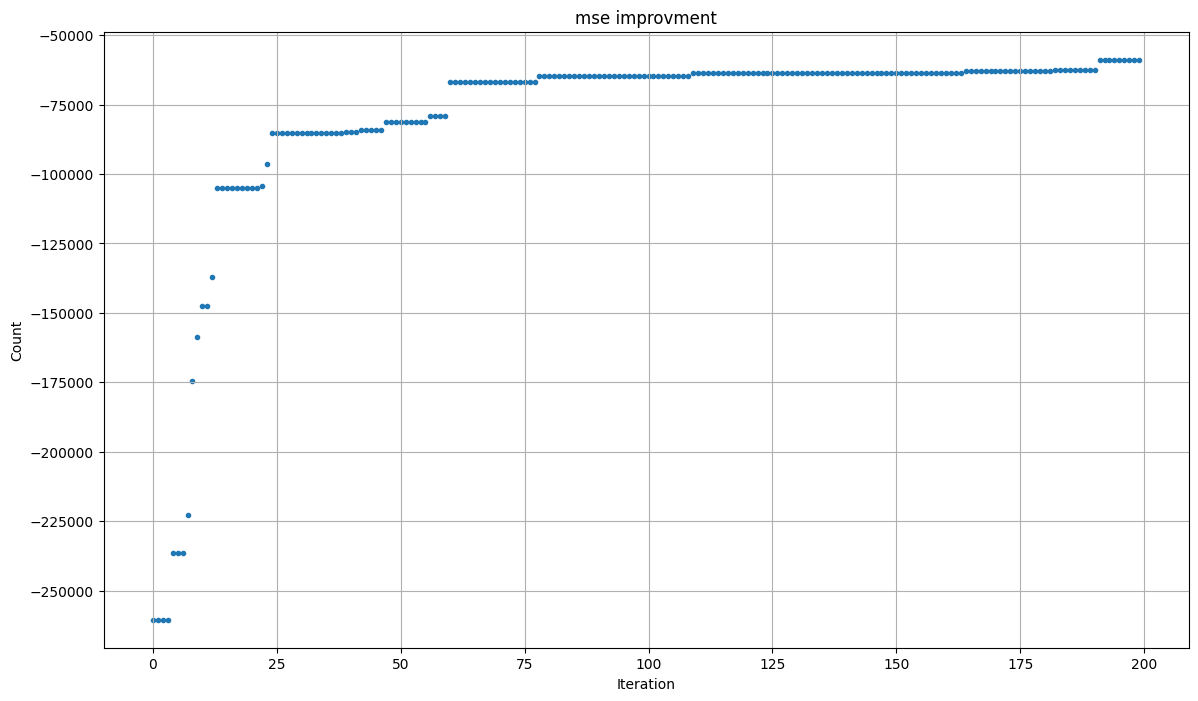

In [4406]:
#from itertools import accumulate
from matplotlib import pyplot as plt

#valid = [sol.fitness for sol in list(accumulate(history, max))]
#Array of all costs only
costs = [sol.fitness[1] for sol in history]
#Plot
plt.figure(figsize=(14, 8))             
plt.title("mse improvment")
plt.grid()

plt.scatter(range(len(costs)), costs, marker=".")

plt.xlabel('Iteration')
plt.ylabel('Count')

In [4407]:
print([x[:,i] for i in range(x.shape[1])])
print([y[i] for i in range(len(y))])

[array([ 1.52827812, -2.67876092, -3.73351453]), array([ 1.19068396, -4.91356563, -3.40695722]), array([ 2.57175475, -1.45454681, -4.72720448]), array([-3.19371133,  3.33638511,  0.08037607]), array([ 2.6796489 , -1.44737742,  2.14213774]), array([ 0.01151075,  0.33079997, -1.3676105 ]), array([ 2.07990979, -3.07409165,  0.00597433]), array([ 2.31118139, -2.55328289, -1.66346104]), array([ 4.64378819,  4.54061843, -0.07800742]), array([-1.97904123,  2.02572755, -0.21281741]), array([-1.46661861, -1.74278122,  1.5854129 ]), array([ 2.28018697, -1.16447391,  4.57279196]), array([ 2.60085069, -3.96438264,  4.21658767]), array([-2.88893476,  1.79792395, -1.99922135]), array([ 4.19596556, -1.0794096 , -3.76427371]), array([ 0.62795057, -0.0389239 , -2.67411439]), array([-4.24952676,  2.45392829,  3.26954804]), array([2.3194163 , 0.91081823, 0.68375488]), array([ 1.35261815, -0.32045952, -2.85960572]), array([-4.48157306,  4.62853705, -1.86364867]), array([0.50596365, 2.59814082, 0.97114336]